## MOIRAI Usage Example

### Key features of the model:
- **Multi-patch Layers:** Adapts to different granularities (frequencies) - different patch size for each granularity
- **Probabilistic:** Predicts params of mix of distributions along with a confidence score for each distribution

### Loading MOIRAI Model

In [1]:
# External imports
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random

src_path = os.path.abspath(os.path.join("src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Local imports
# from samay.dataset import MoiraiDataset
from samay.moirai import MoiraiDataset
from samay.model import MoiraiTSModel

# Load the pretrained model
repo = "Salesforce/moirai-moe-1.0-R-small"
config = {
        "context_len": 128,
        "horizon_len": 64,
        "num_layers": 100,
        "model_type": "moirai-moe",
        "model_size": "small"
    }

moirai_model = MoiraiTSModel(repor=repo, config=config)

### Define the datasets

In [2]:
# Config for the electric transformer temperature dataset
data_config = {"name" : "ett",
                "path" : "../src/samay/models/moment/data/ETTh1.csv",
                "date_col" : "date",
                "freq": "h"
            }

df = pd.read_csv(data_config["path"])
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


Here, we have 6 input features (all form `input_ts`) and the target column is the *Oil Temperature* (`OT`)

In [3]:
# Train and test datasets
train_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="train",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
    normalize=False
)
test_dataset = MoiraiDataset(
    name=data_config['name'],
    mode="test",
    path=data_config['path'],
    datetime_col=data_config['date_col'],
    freq=data_config['freq'],
    context_len=config['context_len'],
    horizon_len=config['horizon_len'],
    normalize=False
)

In [4]:
print([x for x in dir(train_dataset) if "__" not in x],end=" ")

['_preprocess', '_read_data', 'batch_size', 'batchsize', 'boundaries', 'context_len', 'data', 'data_path', 'dataset', 'datetime_col', 'freq', 'gen_test_data', 'gen_train_val_data', 'get_data_loader', 'horizon_len', 'htune', 'mode', 'name', 'normalize', 'patch_size', 'preprocess', 'save', 'start_date', 'ts_cols'] 

`data` is of `pd.DataFrame` type and `dataset` is of `gluonts.datatset` type

In [5]:
train_all = [x for x in iter(train_dataset.dataset)]
len(train_all), train_all[0], len(train_all[0]["target"])

(7,
 {'start': Period('2016-07-01 00:00', 'H'),
  'target': array([ 5.82700014,  5.69299984,  5.15700006, ...,  1.60800004,
         -7.50199986,  5.96099997]),
  'item_id': 'HUFL'},
 13936)

So, `train_dataset` has time series of all the 7 variables (6 independent and 1 dependent). Each of these has `13936` (`80%` of the data) datapoints. Next, we look at the `test_dataset`

In [6]:
test_all = [x for x in iter(test_dataset.dataset)]
len(test_all), test_all[0]

(378,
 ({'start': Period('2016-07-01 00:00', 'H'),
   'target': array([ 5.82700014,  5.69299984,  5.15700006, ...,  1.60800004,
          -7.50199986,  5.96099997]),
   'item_id': 'HUFL'},
  {'start': Period('2016-07-01 00:00', 'H'),
   'target': array([  3.68400002,  13.32900047,  15.60599995,  18.68700027,
           18.01799965,  16.94599915,  16.6779995 ,  16.00799942,
           15.06999969,  14.19999981,  14.2670002 ,  14.73600006,
           13.86499977,  12.92700005,  12.72599983,  14.80300045,
           13.32900047,   2.00900006,  -4.95699978,  -5.55900002,
          -10.44900036,  -3.54999995,  -2.14299989,   1.47399998,
            6.296     ,  12.99400043,  15.60599995,  17.75      ,
           17.28100014,  17.61599922,  15.8739996 ,  16.87899971,
           16.34300041,  14.46800041,  14.93700027,  13.9989996 ,
           13.79800034,  14.19999981,  13.79800034,  16.34300041,
           15.47200012,   4.62200022,  -4.62200022,  -8.70699978,
           -7.76999998,   0.40

There are two parts to each instance (window) in `test_all` - the `input` (history) and the `label` which consists of the true value of the forecast

In [7]:
len(test_all[0][0]["target"]), len(test_all[0][1]["target"])

(13936, 64)

### Evaluate zero-shot forecasting

In [8]:
eval_results, trues, preds, histories = moirai_model.evaluate(test_dataset, metrics=["MSE", "MASE"])
print(eval_results)

{'MSE': 15.12894363568172, 'MASE': 2.0995636531160162}


### Visualise forecast for a given window

In [9]:
random.seed(42)
window_index = random.randint(0, len(histories) - 1)
variate_no = random.randint(0, histories[window_index].shape[0] - 1)
print(f"Window index: {window_index}, Variate no: {variate_no}")

Window index: 40, Variate no: 0


In [10]:
history = histories[window_index][variate_no, -config["context_len"]:]
true = trues[window_index][variate_no, :]
pred = preds[window_index][variate_no, :]

len(history), len(true), len(pred)

(128, 64, 64)

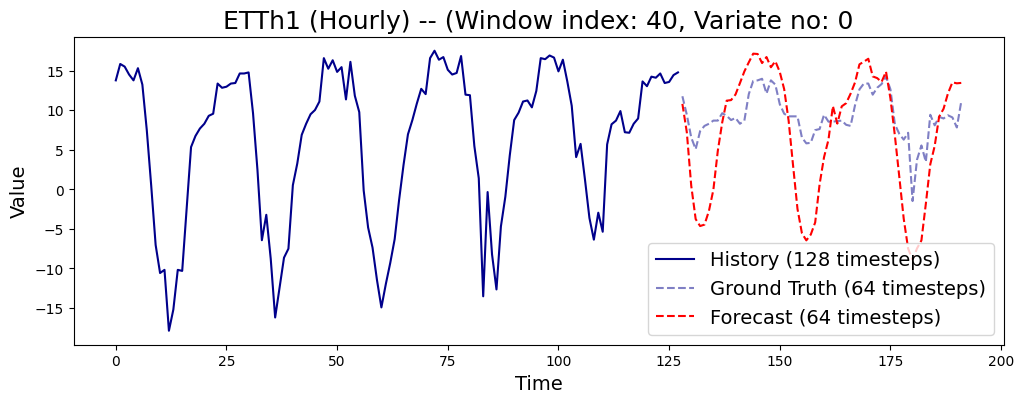

In [11]:
plt.figure(figsize=(12, 4))
num_forecasts = len(true)
offset = len(history)

# Plotting the first time series from history
plt.plot(range(offset), history, label=f"History ({offset} timesteps)", c="darkblue")

# Plotting ground truth and prediction
plt.plot(
    range(offset, offset + num_forecasts),
    true,
    label=f"Ground Truth ({num_forecasts} timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + num_forecasts),
    pred,
    label=f"Forecast ({num_forecasts} timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (Window index: {window_index}, Variate no: {variate_no}", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Finetune MOIRAI on ETT Dataset

In [ ]:
import yaml

path = "../src/samay/models/uni2ts/cli/conf/finetune/model/moirai_small.yaml"
with open(path, "r") as file:
    fin_config = yaml.safe_load(file)

fin_config

In [ ]:
finetuned_model = moirai_model.finetune(train_dataset)